In [554]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [555]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [556]:
train_X= train_X.reshape(60000, 784)
test_X=test_X.reshape(10000, 784)

In [557]:
train_y=train_y.reshape(60000,1)
test_y=test_y.reshape(10000,1)

In [558]:
print(train_X.shape)
print(train_y.shape)

(60000, 784)
(60000, 1)


In [13]:
A = np.array([0, 1, 2])

B = np.array([[ 0,  1,  2,  3],
              [ 4,  5,  6,  7],
              [ 8,  9, 10, 11]])
print(A[:,np.newaxis].shape)
(A[:, np.newaxis] * B)

(3, 1)


array([[ 0,  0,  0,  0],
       [ 4,  5,  6,  7],
       [16, 18, 20, 22]])

# EM FULL IMPLEMENTATION

In [16]:
class EM__:
    
    def __init__(self, clusters_n=2):
        
        self.clusters_n = clusters_n
        
    def fit(self, X_data, iterations=100):
        
        self.iteration_n=iterations
        
        n_samples, n_dimension =  X_data.shape
        
        print(n_samples, n_dimension)
        
        init_means = np.random.choice(n_samples, self.clusters_n,replace=False)
        
        self.means = X_data[init_means,:]
        
        self.convariance = np.stack([np.eye(n_dimension)]* self.clusters_n,axis=0)
        
        print(self.means.shape, self.convariance.shape)

        
        self.mixing_coeffs = np.full(self.clusters_n,1/self.clusters_n)
        
        for i in range(self.iteration_n):
            
            self.responsibilities = self.E_step(X_data)
                
            self.M_step(X_data)
            
        return self.means, self.covariance
    
    def E_step(self, X_data):
        
        responsibilties = np.zeros( [X_data.shape[0], self.clusters_n])
        
        D =[ (np.linalg.det(self.convariance[j]))**0.5 for j in range(self.clusters_n)]
        
        Inv= [ np.linalg.inv(self.convariance[j]) for j in range(self.clusters_n)]
        
        for i in range(X_data.shape[0]):
            
            for j in range(self.clusters_n):
                
                responsibilties[i,j]= self.mixing_coeffs[j]/(D[j]) * np.exp(-0.5 * np.matmul( np.matmul((X_data[i]-self.means[j]).T, Inv[j]), X_data[i]-self.means[j]))   
        
        responsibilties =np.array(responsibilties)
        
        responsibilties = responsibilties/(np.sum(responsibilties,axis=1,keepdims=True))

        return responsibilties
    
    
    def M_step(self, X_data):
        
        n_samples, n_dimension =  X_data.shape
        
        resp = self.responsibilities
        
        print(resp[1])
        
        new_mean = np.ones([self.clusters_n, n_dimension])
        
        print(new_mean.shape)
        
        
        for i in range(self.clusters_n):
            
            new_mean[i] = np.sum (resp[:,i:i+1]*X_data ,axis=0 )/np.sum(resp[:,i],axis=0)
        
        self.means = new_mean
        
        new_cov = np.zeros_like(self.convariance)
        
        for j in range(self.clusters_n):
            
            for i in range(n_samples):
                
                new_cov[j] += resp[i,j] * np.matmul( (X_data[i]-self.means[j])[:,np.newaxis], (X_data[i]-self.means[j])[:,np.newaxis].T )
            
            new_cov[j] = new_cov[j]/np.sum(resp[:,j])
        
        self.convariance = new_cov
        
        self.mixing_coeffs  = resp.sum()/X_data.shape[0]
    
    def predict(self,X):
        
        Init_W = self.E_Step(X)
        
        predicted = Init_W.argmax(axis=0)
        
        clusters = np.copy(X)
        
        for i,mean in enumerate(self.means):
            
            clusters[pred==i] = mean
        
        return clusters
        

In [17]:
#The singularity problem is a strong problem that restricts the running of this model
#source: https://nianlonggu.com/2019/07/10/tutorial-on-EM/

# EXPERIMENTING WITH SKLEARN

In [462]:
z= StandardScaler()
train_X= z.fit_transform(train_X)
test_X= z.fit_transform(test_X)

In [463]:
EM= GaussianMixture(n_components = 10,covariance_type='full', max_iter=200)
EM.fit(train_X)

GaussianMixture(max_iter=200, n_components=10)

In [464]:
train_predicted= EM.predict(train_X)
test_predicted= EM.predict(test_X)

In [465]:
(tr_x, tr_y), (ts_x, ts_y) = mnist.load_data()
y_var=[]
for i in range(10):
    row = np.where(train_predicted==i)[0]  
    num = row.shape[0]      
    print("cluster "+str(i))
    print(str(num)+" elements")
    l=[]
    for k in range(num):
        l.append(tr_y[row[k]])
    y_var.append(l)

cluster 0
7716 elements
cluster 1
9846 elements
cluster 2
3172 elements
cluster 3
2208 elements
cluster 4
7435 elements
cluster 5
2564 elements
cluster 6
2320 elements
cluster 7
14904 elements
cluster 8
4693 elements
cluster 9
5142 elements


In [467]:
import collections
i=0
for l in y_var:
    counter=collections.Counter(l)
    print("cluster", i)
    print(counter)
    i+=1

cluster 0
Counter({7: 3607, 9: 2653, 4: 654, 1: 560, 3: 92, 8: 91, 5: 55, 0: 2, 2: 2})
cluster 1
Counter({0: 3739, 2: 2476, 3: 952, 6: 739, 5: 732, 4: 527, 8: 488, 1: 92, 7: 53, 9: 48})
cluster 2
Counter({1: 3131, 2: 11, 8: 11, 7: 7, 3: 5, 4: 3, 6: 2, 9: 1, 5: 1})
cluster 3
Counter({2: 1219, 3: 351, 6: 301, 0: 80, 4: 79, 5: 76, 8: 47, 1: 31, 9: 16, 7: 8})
cluster 4
Counter({4: 2883, 9: 2483, 7: 1156, 8: 326, 1: 203, 3: 192, 5: 145, 2: 41, 6: 3, 0: 3})
cluster 5
Counter({7: 1050, 3: 404, 9: 398, 4: 271, 8: 154, 2: 126, 5: 112, 0: 35, 1: 9, 6: 5})
cluster 6
Counter({2: 920, 3: 856, 5: 159, 6: 147, 4: 104, 0: 66, 8: 28, 1: 24, 7: 9, 9: 7})
cluster 7
Counter({8: 3666, 3: 2958, 1: 2475, 5: 1898, 0: 1806, 2: 891, 4: 698, 6: 231, 9: 180, 7: 101})
cluster 8
Counter({5: 2154, 8: 1014, 4: 554, 7: 273, 3: 240, 9: 162, 0: 119, 1: 102, 6: 51, 2: 24})
cluster 9
Counter({6: 4439, 2: 248, 1: 115, 5: 89, 3: 81, 0: 73, 4: 69, 8: 26, 9: 1, 7: 1})


In [468]:
#MAnual Declaration of the clusters centers with the most frequen number in that cluster
#Avoiding the repetition by taking the next frequent number if the first is already a center of another cluster
dict={}
dict[0]=7
dict[1]=0 
dict[2]=1 
dict[3]=2 
dict[4]=4 
dict[5]=3 
dict[6]=9
dict[7]=8 
dict[8]=5 
dict[9]=6

In [470]:
predicted=[]
for i in train_predicted:
    predicted.append(dict[i])
print(classification_report(train_y,predicted))

              precision    recall  f1-score   support

           0       0.38      0.63      0.47      5923
           1       0.99      0.46      0.63      6742
           2       0.55      0.20      0.30      5958
           3       0.16      0.07      0.09      6131
           4       0.39      0.49      0.43      5842
           5       0.46      0.40      0.43      5421
           6       0.86      0.75      0.80      5918
           7       0.47      0.58      0.52      6265
           8       0.25      0.63      0.35      5851
           9       0.00      0.00      0.00      5949

    accuracy                           0.42     60000
   macro avg       0.45      0.42      0.40     60000
weighted avg       0.46      0.42      0.41     60000



# Using the Contingency Matrix

In [472]:
from sklearn.metrics.cluster import contingency_matrix
m = np.argmax(contingency_matrix(train_y, train_predicted), axis=1)

In [473]:
print(classification_report(m[train_y], train_predicted))

              precision    recall  f1-score   support

           0       0.81      0.51      0.63     12214
           1       0.63      0.52      0.57     11881
           2       0.99      0.46      0.63      6742
           3       0.00      0.00      0.00         0
           4       0.39      0.49      0.43      5842
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.44      0.55      0.49     11982
           8       0.46      0.40      0.43      5421
           9       0.86      0.75      0.80      5918

    accuracy                           0.53     60000
   macro avg       0.46      0.37      0.40     60000
weighted avg       0.65      0.53      0.57     60000



C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


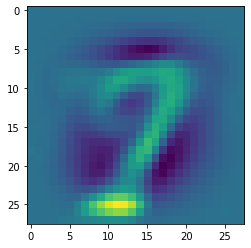

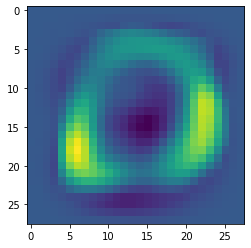

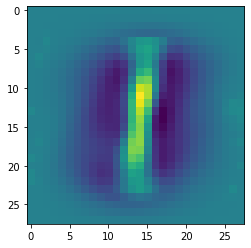

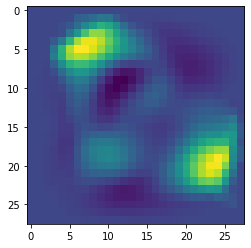

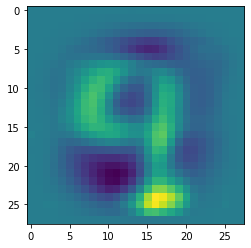

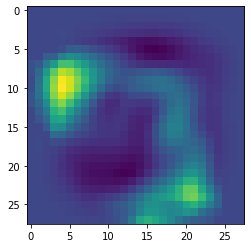

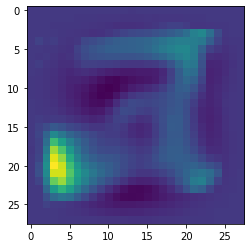

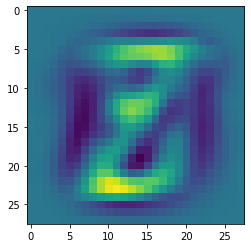

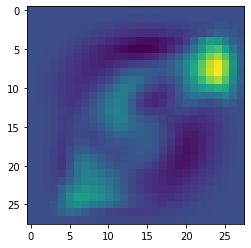

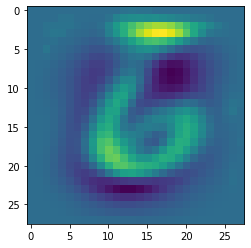

In [477]:
mean_vector = EM.means_
for v in mean_vector:
    plt.imshow(v.reshape(28,28)) 
    plt.show()